In [18]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer, average_precision_score
from sklearn.pipeline import Pipeline
import dagshub
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [7]:
df = pd.read_csv("Churn_Modelling.csv")
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)
target = 'Exited'
categorical_features = ['Geography', 'Gender']
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 
                      'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

X = df.drop(columns=[target])
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", SVC(probability=True, class_weight="balanced", random_state=42))
])

In [ ]:
THRESHOLD = 0.40

def threshold_scorer(estimator, X, y):
    y_prob = estimator.predict_proba(X)[:, 1]
    y_pred = (y_prob >= THRESHOLD).astype(int)
    return f1_score(y, y_pred)

custom_scorer = make_scorer(threshold_scorer, greater_is_better=True)


In [5]:
param_grid = {
    "model__C": [0.1, 1, 10, 50],
    "model__gamma": ["scale", 0.01, 0.1, 1],
    "model__kernel": ["rbf"]
}


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Define features
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
categorical_features = ['Geography', 'Gender']

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)




In [8]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2
)


In [9]:
# ========================== CONFIG ==========================
CONFIG = {
    "experiment_name": "hyperparameter tunng for customer churn SVM",
    "mlflow_uri": "https://dagshub.com/VIKR4NT10/codesoft.mlflow",
    "repo_owner": "VIKR4NT10",
    "repo_name": "codesoft"
}

# ========================== MLflow + DAGsHub ==========================
mlflow.set_tracking_uri(CONFIG["mlflow_uri"])
dagshub.init(
    repo_owner=CONFIG["repo_owner"],
    repo_name=CONFIG["repo_name"],
    mlflow=True
)
mlflow.set_experiment(CONFIG["experiment_name"])

Accessing as VIKR4NT10

Initialized MLflow to track repo "VIKR4NT10/codesoft"

Repository VIKR4NT10/codesoft initialized!

2026/01/24 22:02:10 INFO mlflow.tracking.fluent: Experiment with name 'hyperparameter tunng for customer churn SVM' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/e5e28563e346439990850c06ac9bed14', creation_time=1769272286155, experiment_id='10', last_update_time=1769272286155, lifecycle_stage='active', name='hyperparameter tunng for customer churn SVM', tags={}>

In [10]:
mlflow.set_experiment("churn_svm_hyperparameter_experiment")

with mlflow.start_run():
    
    # Fit GridSearch
    grid_search.fit(X_train, y_train)
    
    # Best estimator
    best_model = grid_search.best_estimator_
    
    # Log hyperparameters
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_param("threshold", THRESHOLD)
    
    # Evaluate on test set
    y_prob = best_model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= THRESHOLD).astype(int)
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    pct_flagged = y_pred.mean()
    
    # Log metrics
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("pct_customers_flagged", pct_flagged)
    
    # Log model
    mlflow.sklearn.log_model(best_model, artifact_path="svm_model")
    
    print(f"Best Params: {grid_search.best_params_}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, % flagged: {pct_flagged:.4f}")


2026/01/24 22:02:16 INFO mlflow.tracking.fluent: Experiment with name 'churn_svm_hyperparameter_experiment' does not exist. Creating a new experiment.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


c:\Users\DELL\.conda\envs\titan\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
2026/01/24 22:22:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best Params: {'model__C': 0.1, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Precision: 0.6401, Recall: 0.5725, F1: 0.6044, % flagged: 0.1820
🏃 View run awesome-kit-745 at: https://dagshub.com/VIKR4NT10/codesoft.mlflow/#/experiments/11/runs/2b3e7ec473374c38a6331525c5c6797a
🧪 View experiment at: https://dagshub.com/VIKR4NT10/codesoft.mlflow/#/experiments/11


In [11]:
import mlflow.xgboost

from xgboost import XGBClassifier

In [12]:
THRESHOLD = 0.35

def threshold_scorer(estimator, X, y):
    y_prob = estimator.predict_proba(X)[:, 1]
    y_pred = (y_prob >= THRESHOLD).astype(int)
    return f1_score(y, y_pred)

custom_scorer = make_scorer(threshold_scorer, greater_is_better=True)


In [13]:
param_grid = {
    "model__n_estimators": [50, 100, 200],
    "model__max_depth": [3, 5, 7],
    "model__learning_rate": [0.01, 0.1, 0.2],
    "model__subsample": [0.7, 0.9, 1.0],
    "model__colsample_bytree": [0.7, 0.9, 1.0]
}


In [14]:
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

In [ ]:

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2
)


In [23]:
mlflow.set_experiment("churn_xgboost_experiment")

with mlflow.start_run():
    
    # Fit GridSearch
    grid_search.fit(X_train, y_train)
    
    # Best estimator
    best_model = grid_search.best_estimator_
    
    # Log hyperparameters
    mlflow.log_params(grid_search.best_params_)
    
    # -----------------------------
    # Evaluate on test set using fixed threshold
    # -----------------------------
    THRESHOLD = 0.35  # your chosen threshold
    y_prob = best_model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= THRESHOLD).astype(int)
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    pct_flagged = y_pred.mean()
    
    # Log metrics
    mlflow.log_param("threshold", THRESHOLD)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("pct_customers_flagged", pct_flagged)
    
    # Log PR-AUC
    pr_auc_test = average_precision_score(y_test, y_prob)
    mlflow.log_metric("pr_auc", pr_auc_test)
    
    # -----------------------------
    # Print summary
    # -----------------------------
    print(f"Best Params: {grid_search.best_params_}")
    print(f"Threshold: {THRESHOLD:.2f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, % flagged: {pct_flagged:.4f}")
    print(f"Test PR-AUC: {pr_auc_test:.4f}")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


c:\Users\DELL\.conda\envs\titan\lib\site-packages\xgboost\training.py:199: UserWarning: [23:36:45] WARNING: D:\bld\xgboost-split_1767713749021\work\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Params: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.2, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 0.9}
Threshold: 0.35
Precision: 0.6501, Recall: 0.6118, F1: 0.6304, % flagged: 0.1915
Test PR-AUC: 0.7166
🏃 View run ambitious-koi-928 at: https://dagshub.com/VIKR4NT10/codesoft.mlflow/#/experiments/12/runs/08816715758f4501baa43434b000027d
🧪 View experiment at: https://dagshub.com/VIKR4NT10/codesoft.mlflow/#/experiments/12


In [50]:
# ===============================
# SCRIPT A: RAW FEATURES ONLY
# ===============================

import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score

from xgboost import XGBClassifier

# -------------------------------
# Load data
# -------------------------------
df = pd.read_csv("Churn_Modelling.csv")
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

X = df.drop(columns=['Exited'])
y = df['Exited']

# -------------------------------
# Feature groups (RAW)
# -------------------------------
numerical_features = [
    'CreditScore', 'Age', 'Tenure', 'Balance',
    'NumOfProducts', 'HasCrCard',
    'IsActiveMember', 'EstimatedSalary'
]

categorical_features = ['Geography', 'Gender']

# -------------------------------
# Preprocessing
# -------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False),
         categorical_features)
    ]
)

# -------------------------------
# Model
# -------------------------------
model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

# -------------------------------
# Fixed threshold
# -------------------------------
THRESHOLD = 0.30

def threshold_f1(estimator, X, y):
    y_prob = estimator.predict_proba(X)[:, 1]
    y_pred = (y_prob >= THRESHOLD).astype(int)
    return f1_score(y, y_pred)

# -------------------------------
# CV + Hyperparameters
# -------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.7, 0.9, 1.0],
    'model__colsample_bytree': [0.7, 0.9, 1.0]
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=threshold_f1,
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# -------------------------------
# Run tuning
# -------------------------------
grid_search.fit(X, y)

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
    roc_auc_score
)

# ----------------------------------
# Cross-validated evaluation
# ----------------------------------
best_model = grid_search.best_estimator_

metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'pr_auc': [],
    'roc_auc': []
}

THRESHOLD = 0.30

for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    best_model.fit(X_train, y_train)

    y_prob = best_model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= THRESHOLD).astype(int)

    metrics['accuracy'].append(accuracy_score(y_test, y_pred))
    metrics['precision'].append(precision_score(y_test, y_pred))
    metrics['recall'].append(recall_score(y_test, y_pred))
    metrics['f1'].append(f1_score(y_test, y_pred))
    metrics['pr_auc'].append(average_precision_score(y_test, y_prob))
    metrics['roc_auc'].append(roc_auc_score(y_test, y_prob))

# ----------------------------------
# Report results
# ----------------------------------
print("\nCROSS-VALIDATED METRICS (threshold = 0.35)")
for metric, values in metrics.items():
    print(f"{metric.upper():10s}: {np.mean(values):.4f} ± {np.std(values):.4f}")
print("Best Params:")
print(grid_search.best_params_)



Fitting 5 folds for each of 243 candidates, totalling 1215 fits


c:\Users\DELL\.conda\envs\titan\lib\site-packages\xgboost\training.py:199: UserWarning: [23:45:37] WARNING: D:\bld\xgboost-split_1767713749021\work\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\DELL\.conda\envs\titan\lib\site-packages\xgboost\training.py:199: UserWarning: [23:45:37] WARNING: D:\bld\xgboost-split_1767713749021\work\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\DELL\.conda\envs\titan\lib\site-packages\xgboost\training.py:199: UserWarning: [23:45:38] WARNING: D:\bld\xgboost-split_1767713749021\work\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\DELL\.conda\envs\titan\lib\site-packages\xgboost\training.py:199: UserWarning: [23:45:38] WARNING: D:\bld\xgboost-split_1767713749021\work\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are


CROSS-VALIDATED METRICS (threshold = 0.35)
ACCURACY  : 0.8459 ± 0.0086
PRECISION : 0.6147 ± 0.0216
RECALL    : 0.6539 ± 0.0253
F1        : 0.6335 ± 0.0205
PR_AUC    : 0.7091 ± 0.0123
ROC_AUC   : 0.8664 ± 0.0069
Best Params:
{'model__colsample_bytree': 0.7, 'model__learning_rate': 0.2, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 1.0}


In [36]:
# =============================
# SHAP (VERSION-PROOF)
# =============================

import shap
import numpy as np
import pandas as pd

# -----------------------------
# Transform training data
# -----------------------------
X_train_transformed = pipeline.named_steps['preprocessor'] \
    .transform(X_train) \
    .astype(np.float32)

feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# -----------------------------
# Callable wrapper
# -----------------------------
xgb_model = pipeline.named_steps['model']

def model_predict(X):
    return xgb_model.predict_proba(X)[:, 1]

# -----------------------------
# SHAP Explainer (PERMUTATION)
# -----------------------------
explainer = shap.Explainer(
    model_predict,
    X_train_transformed,
    feature_names=feature_names
)

shap_values = explainer(X_train_transformed).values

# -----------------------------
# SHAP importance table
# -----------------------------
shap_importance = (
    pd.DataFrame({
        "feature": feature_names,
        "mean_abs_shap": np.abs(shap_values).mean(axis=0)
    })
    .sort_values("mean_abs_shap", ascending=False)
)

print(shap_importance.head(10))


PermutationExplainer explainer: 8001it [33:25,  3.99it/s]                            


                   feature  mean_abs_shap
1                 num__Age       0.101559
4       num__NumOfProducts       0.090504
6      num__IsActiveMember       0.048621
3             num__Balance       0.031095
9   cat__Geography_Germany       0.022380
0         num__CreditScore       0.021664
7     num__EstimatedSalary       0.021600
11      cat__Gender_Female       0.021412
2              num__Tenure       0.010118
8    cat__Geography_France       0.009431


C:\Users\DELL\AppData\Local\Temp\ipykernel_6548\746884619.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names)


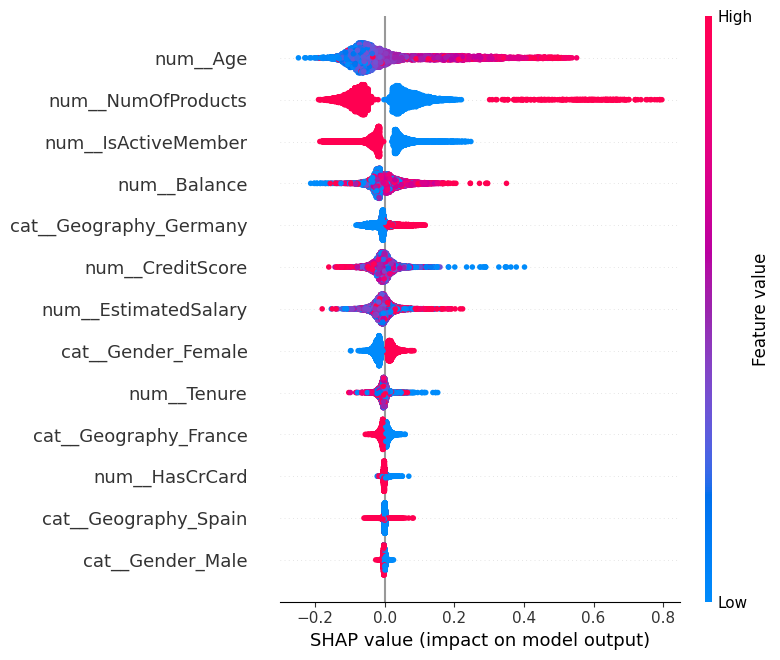

In [37]:
shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names)



C:\Users\DELL\AppData\Local\Temp\ipykernel_6548\3652285224.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names, plot_type="bar")


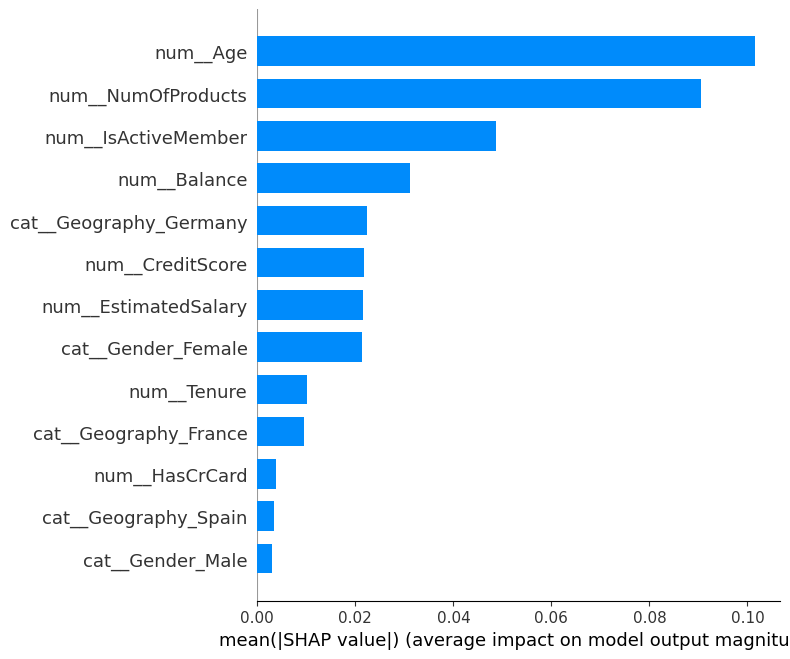

In [38]:
shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names, plot_type="bar")

In [45]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
import pandas as pd
import numpy as np

# -----------------------------
# Hard-coded top features
# -----------------------------
top6_features = [
    'Age',
    'NumOfProducts',
    'IsActiveMember',
    'Balance',
    'Geography_Germany',
    'CreditScore'
]

top8_features = [
    'Age',
    'NumOfProducts',
    'IsActiveMember',
    'Balance',
    'Geography_Germany',
    'CreditScore',
    'EstimatedSalary',
    'Gender_Female'
]

# -----------------------------
# One-hot encode categorical columns
# -----------------------------
X_enc = pd.get_dummies(X, columns=['Geography', 'Gender'], drop_first=False)
X_enc = X_enc.reindex(columns=X_enc.columns.union(top8_features), fill_value=0)

y = df[target]

# -----------------------------
# Cross-validation function
# -----------------------------
def cross_val_xgb(X, y, features, threshold=0.35, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    metrics_list = []
    
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx][features], X.iloc[test_idx][features]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model = XGBClassifier(
            n_estimators=100,
            max_depth=3,
            learning_rate=0.2,
            subsample=1.0,
            colsample_bytree=0.7,
            eval_metric='logloss',
            use_label_encoder=False,
            random_state=42
        )
        model.fit(X_train, y_train)
        y_prob = model.predict_proba(X_test)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)
        
        metrics_list.append({
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred),
            "ROC-AUC": roc_auc_score(y_test, y_prob),
            "PR-AUC": average_precision_score(y_test, y_prob),
            "% Flagged": y_pred.mean()
        })
    
    metrics_df = pd.DataFrame(metrics_list)
    return metrics_df.mean().to_dict(), metrics_df.std().to_dict()

# -----------------------------
# Evaluate Top 6
# -----------------------------
mean6, std6 = cross_val_xgb(X_enc, y, top6_features, threshold=0.30)
print("=== Top 6 Features (threshold=0.35) ===")
for k in mean6.keys():
    print(f"{k}: {mean6[k]:.4f} ± {std6[k]:.4f}")

# -----------------------------
# Evaluate Top 8
# -----------------------------
mean8, std8 = cross_val_xgb(X_enc, y, top8_features, threshold=0.30)
print("\n=== Top 8 Features (threshold=0.35) ===")
for k in mean8.keys():
    print(f"{k}: {mean8[k]:.4f} ± {std8[k]:.4f}")


c:\Users\DELL\.conda\envs\titan\lib\site-packages\xgboost\training.py:199: UserWarning: [23:17:34] WARNING: D:\bld\xgboost-split_1767713749021\work\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\DELL\.conda\envs\titan\lib\site-packages\xgboost\training.py:199: UserWarning: [23:17:35] WARNING: D:\bld\xgboost-split_1767713749021\work\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\DELL\.conda\envs\titan\lib\site-packages\xgboost\training.py:199: UserWarning: [23:17:35] WARNING: D:\bld\xgboost-split_1767713749021\work\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\DELL\.conda\envs\titan\lib\site-packages\xgboost\training.py:199: UserWarning: [23:17:35] WARNING: D:\bld\xgboost-split_1767713749021\work\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are

=== Top 6 Features (threshold=0.35) ===
Accuracy: 0.8443 ± 0.0087
Precision: 0.6104 ± 0.0212
Recall: 0.6524 ± 0.0237
F1: 0.6306 ± 0.0201
ROC-AUC: 0.8637 ± 0.0072
PR-AUC: 0.7061 ± 0.0164
% Flagged: 0.2178 ± 0.0069


c:\Users\DELL\.conda\envs\titan\lib\site-packages\xgboost\training.py:199: UserWarning: [23:17:36] WARNING: D:\bld\xgboost-split_1767713749021\work\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\DELL\.conda\envs\titan\lib\site-packages\xgboost\training.py:199: UserWarning: [23:17:36] WARNING: D:\bld\xgboost-split_1767713749021\work\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\DELL\.conda\envs\titan\lib\site-packages\xgboost\training.py:199: UserWarning: [23:17:36] WARNING: D:\bld\xgboost-split_1767713749021\work\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\DELL\.conda\envs\titan\lib\site-packages\xgboost\training.py:199: UserWarning: [23:17:37] WARNING: D:\bld\xgboost-split_1767713749021\work\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are


=== Top 8 Features (threshold=0.35) ===
Accuracy: 0.8460 ± 0.0080
Precision: 0.6142 ± 0.0220
Recall: 0.6588 ± 0.0210
F1: 0.6355 ± 0.0162
ROC-AUC: 0.8674 ± 0.0071
PR-AUC: 0.7090 ± 0.0134
% Flagged: 0.2187 ± 0.0096


In [66]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

# For target encoding
from category_encoders import TargetEncoder

# -----------------------------
# Top SHAP features (hard-coded)
# -----------------------------
top6_features = ['Age','NumOfProducts','IsActiveMember','Balance','Geography_Germany','CreditScore']
top8_features = top6_features + ['EstimatedSalary','Gender_Female']

# -----------------------------
# One-hot encode categorical
# -----------------------------
X_oh = pd.get_dummies(df[categorical_features + numerical_features], 
                      columns=categorical_features, drop_first=False)
X_oh = X_oh.reindex(columns=X_oh.columns.union(top8_features), fill_value=0)
y = df[target]

# -----------------------------
# Helper: cross-validate XGB with optional resampling
# -----------------------------
def cross_val_xgb_resample(X, y, features, threshold=0.35, n_splits=5, resampler=None):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    metrics_list = []
    
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx][features], X.iloc[test_idx][features]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Apply resampling if provided
        if resampler is not None:
            X_train, y_train = resampler.fit_resample(X_train, y_train)
        
        model = XGBClassifier(
            n_estimators=100,
            max_depth=3,
            learning_rate=0.2,
            subsample=1.0,
            colsample_bytree=0.7,
            eval_metric='logloss',
            use_label_encoder=False,
            random_state=42
        )
        model.fit(X_train, y_train)
        y_prob = model.predict_proba(X_test)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)
        
        metrics_list.append({
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred),
            "ROC-AUC": roc_auc_score(y_test, y_prob),
            "PR-AUC": average_precision_score(y_test, y_prob),
            "% Flagged": y_pred.mean()
        })
    
    metrics_df = pd.DataFrame(metrics_list)
    return metrics_df.mean().to_dict(), metrics_df.std().to_dict()

# -----------------------------
# Compare multiple approaches
# -----------------------------
results = {}

# 1. Baseline all features (one-hot)
mean_all, std_all = cross_val_xgb_resample(X_oh, y, X_oh.columns.tolist(), threshold=0.28)
results['All Features'] = (mean_all, std_all)

# 2. Top 6 features
mean6, std6 = cross_val_xgb_resample(X_oh, y, top6_features, threshold=0.28)
results['Top 6 SHAP'] = (mean6, std6)

# 3. Top 8 features
mean8, std8 = cross_val_xgb_resample(X_oh, y, top8_features, threshold=0.28)
results['Top 8 SHAP'] = (mean8, std8)

# -----------------------------
# Display results
# -----------------------------
metrics = ['Accuracy','Precision','Recall','F1','ROC-AUC','PR-AUC','% Flagged']
final_df = pd.DataFrame(columns=['Approach'] + metrics)

for k, (mean_dict, std_dict) in results.items():
    row = {'Approach': k}
    for m in metrics:
        row[m] = f"{mean_dict[m]:.3f} ± {std_dict[m]:.3f}"
    final_df = pd.concat([final_df, pd.DataFrame([row])], ignore_index=True)

print("\n=== Model Comparison with Target Encoding & SMOTE ===\n")
print(final_df)


c:\Users\DELL\.conda\envs\titan\lib\site-packages\xgboost\training.py:199: UserWarning: [00:07:53] WARNING: D:\bld\xgboost-split_1767713749021\work\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\DELL\.conda\envs\titan\lib\site-packages\xgboost\training.py:199: UserWarning: [00:07:53] WARNING: D:\bld\xgboost-split_1767713749021\work\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\DELL\.conda\envs\titan\lib\site-packages\xgboost\training.py:199: UserWarning: [00:07:54] WARNING: D:\bld\xgboost-split_1767713749021\work\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\DELL\.conda\envs\titan\lib\site-packages\xgboost\training.py:199: UserWarning: [00:07:54] WARNING: D:\bld\xgboost-split_1767713749021\work\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are


=== Model Comparison with Target Encoding & SMOTE ===

       Approach       Accuracy      Precision         Recall             F1  \
0  All Features  0.839 ± 0.010  0.593 ± 0.024  0.671 ± 0.023  0.629 ± 0.020   
1    Top 6 SHAP  0.839 ± 0.008  0.593 ± 0.019  0.668 ± 0.024  0.628 ± 0.019   
2    Top 8 SHAP  0.840 ± 0.010  0.594 ± 0.024  0.679 ± 0.022  0.634 ± 0.020   

         ROC-AUC         PR-AUC      % Flagged  
0  0.867 ± 0.008  0.709 ± 0.016  0.230 ± 0.009  
1  0.864 ± 0.007  0.706 ± 0.016  0.229 ± 0.008  
2  0.867 ± 0.007  0.709 ± 0.013  0.233 ± 0.009  
